In [2]:
import pandas as pd 
import numpy as np

import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [3]:
df_dana = pd.read_csv('dana_reviews.csv')

In [4]:
df_dana.head(10)

,userName,score,at,content
0,Elisya Kasni,5,15-02-24 11:24,Bagus
1,Rusman Man,2,15-02-24 11:24,Dana mmg keren mantap.
2,Qiliw Sadega,1,15-02-24 11:23,Saya ngajuin upgrade dana premium krna ktp say...
3,Kijutjrv2 Kijut,3,15-02-24 11:22,Kocak mana diskon nya ml malah eror segala kag...
4,Fifi Alfiyah,1,15-02-24 11:21,Saldo hilang karena no lama Hilang ganti no sa...
5,Kiki57,3,15-02-24 11:21,mayan
6,Parhan Parhan,1,15-02-24 11:19,Udah gua hapus dana ya. ilang ya udah 1 juta l...
7,Dewi Anggreni,5,15-02-24 11:19,baik
8,Bang Ewok13,1,15-02-24 11:18,TOLONG UNTUK SISTEM KEAMANAN DI PERBAIKI. KALA...
9,M Alifian,5,15-02-24 11:17,mempermudah transfer


In [5]:
df_dana['userName'] = df_dana['userName'].astype(str)
df_dana['content'] = df_dana['content'].astype(str)
df_dana['score'] = df_dana['score'].astype(int)
df_dana['at'] = pd.to_datetime(df_dana['at'])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15464\2877770081.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_dana['at'] = pd.to_datetime(df_dana['at'])


In [6]:
column_dtypes = df_dana.dtypes
print(column_dtypes)

userName            object
score                int32
at          datetime64[ns]
content             object
dtype: object


In [7]:
#Review Selection
# Convert 'at' column to datetime format
df_dana['at'] = pd.to_datetime(df_dana['at'])

# Set the start and end date range
start_date = pd.to_datetime('2022-01-01')
end_date = pd.to_datetime('2024-12-31')

# Filter the DataFrame for data within the specified date range
df_ytd = df_dana[(df_dana['at'] >= start_date) & (df_dana['at'] <= end_date)]

In [8]:
num_records = len(df_ytd)
print("Number of records in df_ytd:", num_records)

Number of records in df_ytd: 50000


In [9]:
start_date = df_ytd['at'].min()
end_date = df_ytd['at'].max()

print("Start Date:", start_date)
print("End Date:", end_date)


Start Date: 2023-12-31 16:28:00
End Date: 2024-12-02 23:58:00


In [10]:
df_textPreprocessing = df_ytd.copy()

In [11]:
#Manual Labelling

# Initialize the label column
df_textPreprocessing['label'] = None

# Iterate over each row in the DataFrame
for index, row in df_textPreprocessing.iterrows():
    review = row['content']
    rating = row['score']
    
    # Manually assign a label based on the rating
    if rating in [1, 2]:
        label = 'Negative'
    elif rating in [4, 5]:
        label = 'Positive'
    else:
        label = 'Neutral'
    
    # Update the 'label' column for the current row
    df_textPreprocessing.at[index, 'label'] = label


In [12]:
# Delete rows with "Neutral" label
df_textPreprocessing = df_textPreprocessing[df_textPreprocessing['label'] != 'Neutral']

# Remove neutral ratings
df_textPreprocessing = df_textPreprocessing[~df_textPreprocessing['score'].isin([3])]


In [13]:
num_records = len(df_textPreprocessing)
print("Number of records in df_textPreprocessing:", num_records)

Number of records in df_textPreprocessing: 47422


In [14]:
columns_to_drop = ['userName', 'at']
df_textPreprocessing = df_textPreprocessing.drop(columns=columns_to_drop)

In [15]:
df_textPreprocessing.tail(10)

,score,content,label
49990,1,Takim,Negative
49991,5,mohon dirahasiakan,Positive
49992,5,Dana mantap,Positive
49993,4,"Amanah, biasanya kerja juga pake apk dana buat...",Positive
49994,5,"Kak tolong perbaiki dana saya, Karena tidak mu...",Positive
49995,5,Bagus,Positive
49996,1,"error, tidak bisa masuk",Negative
49997,5,Cukup membantu,Positive
49998,1,"tolong pihak dana knp saldo saya hilang,ada yg...",Negative
49999,1,good. 👌,Negative


In [16]:
#remove punctuations
df_textPreprocessing['content'] = df_textPreprocessing['content'].str.replace('[^\w]|_',' ')

In [17]:
#remove digit or numbers
df_textPreprocessing['content'] = df_textPreprocessing['content'].str.replace("\d+", " ")

In [18]:
#remove word with digit
df_textPreprocessing['content'] = df_textPreprocessing['content'].str.replace("\S*\d\S*", " ")

In [19]:
#Remove additional white spaces
df_textPreprocessing['content'] = df_textPreprocessing['content'].str.replace('[\s]+', ' ')

In [20]:
# Define the normalization mapping based on KBBI
normalization_mapping = {
    'di': 'di',
    'ini': 'ini',
    'dan': 'dan',
    'ok': 'bagus',
    'nya': 'nya',
    'aku': 'aku',
    'Ok': 'bagus',
    'ada': 'ada',
    'tik': 'tik',
    'Aku': 'aku',
    'yg': 'yang',
    'gak': 'tidak',
    'ga': 'tidak',
    'ku': 'kamu',
    'the': 'the',
    'ya': 'ya',
    '5': 'lima',
    'aja': 'saja',
    'I': 'saya',
    'apk': 'aplikasi',
    '👍': 'bagus',
    'ke': 'ke',
    'mau': 'mau',
    'you': 'kamu',
    'kok': 'kok',
    'gk': 'tidak',
    'fyp': 'fyp',
    'sih': 'sih',
    'apa': 'apa',
    'Apk': 'aplikasi',
    'd': 'di',
    'app': 'aplikasi',
    'itu': 'itu',
    'ok': 'bagus',
    'lah': 'lah',
    'bgt': 'banget',
    'to': 'ke',
    '3': 'tiga',
    'is': 'adalah',
    'ko': 'kamu',
    'Ini': 'ini',
    'nia': 'nia',
    'and': 'dan',
    '2': 'dua',
    'hp': 'handphone',
    'kan': 'kan',
    'deh': 'deh',
    'Top': 'bagus',
    'gua': 'saya',
    'Oke': 'bagus',
    'my': 'saya',
    'i': 'saya',
    'ny': 'nya',
    'dgn': 'dengan',
    'Top.': 'bagus',
    'dagus': 'bagus',
    'bs': 'bisa',
    'senagsekali': 'senang sekali',
    'ferbaiki': 'perbaiki',
    'waifi': 'wifi',
    'The best': 'terbaik',
    'Mantab': 'mantap',
    'bgus': 'bagus',
    'Ko': 'kamu',
    'bgt': 'banget',
    'knp': 'kenapa',
    'jgn': 'jangan',
    'gtw': 'enggak tahu',
    'bsk': 'besok',
    'lgsg': 'langsung',
    'y': 'ya',
    'jg': 'juga',
    'tp': 'tapi',
    'trs': 'terus',
    'jd': 'jadi',
    'pdhl': 'padahal',
    'blm': 'belum',
    'dpt': 'dapat',
    'gk': 'gak',
    'bb': 'badan',
    'mgkn': 'mungkin',
    'sm': 'sama',
    'bngt': 'banget',
    'sgt': 'sangat',
    'gaul': 'keren',
    'cuy': 'bro',
    'mantap': 'bagus',
    'ngab': 'bro',
    'asem': 'asli semangat',
    'pake': 'pakai',
    'mabar': 'main bareng',
    'lahir batin': 'sepenuh hati',
    'tolol': 'bodoh',
    'baper': 'bawa perasaan',
    'wkwk': 'haha',
    'abis': 'habis',
    'wibu': 'penggemar budaya Jepang',
    'asyikkk': 'asyik',
    'baguus': 'bagus',
    'selaluih': 'selalu',
    'mmantap': 'mantap',
    'stabilo': 'stabil',
    'terbaikk': 'terbaik',
    'percumaa': 'percuma',
    'mahall': 'mahal',
    'manstap': 'mantap',
    'terbainya': 'terbaiknya',
    'malahh': 'malah',
    'tulusin': 'tuluskan',
    'gadaa': 'gak ada',
    'tok': 'tiktok',
    'menyedot': 'menghisap',
    'good': 'bagus'
    
}

# Function to perform manual normalization
def normalize_text(text):
    normalized_text = []
    words = text.split()
    for word in words:
        if word in normalization_mapping:
            normalized_word = normalization_mapping[word]
            normalized_text.append(normalized_word)
        else:
            normalized_text.append(word)
    normalized_text = ' '.join(normalized_text)
    return normalized_text

# Apply the text normalization function to the 'content' column
df_textPreprocessing['content'] = df_textPreprocessing['content'].apply(normalize_text)

In [21]:
df_textPreprocessing.head(5)

,score,content,label
0,5,Bagus,Positive
1,2,Dana mmg keren mantap.,Negative
2,1,Saya ngajuin upgrade dana premium krna ktp say...,Negative
4,1,Saldo hilang karena no lama Hilang ganti no sa...,Negative
6,1,Udah saya hapus dana ya. ilang ya udah 1 juta ...,Negative


In [22]:
def case_folding(review):
    # Convert the review to lowercase
    folded_review = review.lower()
    return folded_review

df_textPreprocessing['folded_content'] = df_textPreprocessing['content'].apply(case_folding)

In [23]:
df_textPreprocessing.head(5)

,score,content,label,folded_content
0,5,Bagus,Positive,bagus
1,2,Dana mmg keren mantap.,Negative,dana mmg keren mantap.
2,1,Saya ngajuin upgrade dana premium krna ktp say...,Negative,saya ngajuin upgrade dana premium krna ktp say...
4,1,Saldo hilang karena no lama Hilang ganti no sa...,Negative,saldo hilang karena no lama hilang ganti no sa...
6,1,Udah saya hapus dana ya. ilang ya udah 1 juta ...,Negative,udah saya hapus dana ya. ilang ya udah 1 juta ...


In [24]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Additional stop words
more_stopword = ['sy','n','bgt','banget','d','bu','pak','dengan','dgn','kemaren','kmrin','dear','yth','ass','gak','ny','cari','dibantu','mohon','saja','aja','malam','selamat','sore','siang','pagi','asalamualaikum','wb','wr','assalamualaikum','sya','yg', 'ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara', 'antaranya', 'apa', 'apaan', 'apabila', 'apakah', 'apalagi', 'apatah', 'artinya', 'asal', 'asalkan', 'atas', 'atau', 'ataukah', 'ataupun', 'awal', 'awalnya', 'bagai', 'bagaikan', 'bagaimana', 'bagaimanakah', 'bagaimanapun', 'bagi', 'bagian', 'bahkan', 'bahwa', 'bahwasanya', 'baik', 'bakal', 'bakalan', 'balik', 'banyak', 'bapak', 'baru', 'bawah', 'beberapa', 'begini', 'beginian', 'beginikah', 'beginilah', 'begitu', 'begitukah', 'begitulah', 'begitupun', 'bekerja', 'belakang', 'belakangan', 'belum', 'belumlah', 'benar', 'benarkah', 'benarlah', 'berada', 'berakhir', 'berakhirlah', 'berakhirnya', 'berapa', 'berapakah', 'berapalah', 'berapapun', 'berarti', 'berawal', 'berbagai', 'berdatangan', 'beri', 'berikan', 'berikut', 'berikutnya', 'berjumlah', 'berkali-kali', 'berkata', 'berkehendak', 'berkeinginan', 'berkenaan', 'berlainan', 'berlalu', 'berlangsung', 'berlebihan', 'bermacam', 'bermacam-macam', 'bermaksud', 'bermula', 'bersama', 'bersama-sama', 'bersiap', 'bersiap-siap', 'bertanya', 'bertanya-tanya', 'berturut', 'berturut-turut', 'bertutur', 'berujar', 'berupa', 'besar', 'betul', 'betulkah', 'biasa', 'biasanya', 'bila', 'bilakah', 'bisa', 'bisakah', 'boleh', 'bolehkah', 'bolehlah', 'buat', 'bukan', 'bukankah', 'bukanlah', 'bukannya', 'bulan', 'bung', 'cara', 'caranya', 'cukup', 'cukupkah', 'cukuplah', 'cuma', 'dahulu', 'dalam', 'dan', 'dapat', 'dari', 'daripada', 'datang', 'dekat', 'demi', 'demikian', 'demikianlah', 'dengan', 'depan', 'di', 'dia', 'diakhiri', 'diakhirinya', 'dialah', 'diantara', 'diantaranya', 'diberi', 'diberikan', 'diberikannya', 'dibuat', 'dibuatnya', 'didapat', 'didatangkan', 'digunakan', 'diibaratkan', 'diibaratkannya', 'diingat', 'diingatkan', 'diinginkan', 'dijawab', 'dijelaskan', 'dijelaskannya', 'dikarenakan', 'dikatakan', 'dikatakannya', 'dikerjakan', 'diketahui', 'diketahuinya', 'dikira', 'dilakukan', 'dilalui', 'dilihat', 'dimaksud', 'dimaksudkan', 'dimaksudkannya', 'dimaksudnya', 'diminta', 'dimintai', 'dimisalkan', 'dimulai', 'dimulailah', 'dimulainya', 'dimungkinkan', 'dini', 'dipastikan', 'diperbuat', 'diperbuatnya', 'dipergunakan', 'diperkirakan', 'diperlihatkan', 'diperlukan', 'diperlukannya', 'dipersoalkan', 'dipertanyakan', 'dipunyai', 'diri', 'dirinya', 'disampaikan', 'disebut', 'disebutkan', 'disebutkannya', 'disini', 'disinilah', 'ditambahkan', 'ditandaskan', 'ditanya', 'ditanyai', 'ditanyakan', 'ditegaskan', 'ditujukan', 'ditunjuk', 'ditunjuki', 'ditunjukkan', 'ditunjukkannya', 'ditunjuknya', 'dituturkan', 'dituturkannya', 'diucapkan', 'diucapkannya', 'diungkapkan', 'dong', 'dua', 'dulu', 'empat', 'enggak', 'enggaknya', 'entah', 'entahlah', 'guna', 'gunakan', 'hal', 'hampir', 'hanya', 'hanyalah', 'hari', 'harus', 'haruslah', 'harusnya', 'hendak', 'hendaklah', 'hendaknya', 'hingga', 'ia', 'ialah', 'ibarat', 'ibaratkan', 'ibaratnya', 'ibu', 'ikut', 'ingat', 'ingat-ingat', 'ingin', 'inginkah', 'inginkan', 'ini', 'inikah', 'inilah', 'itu', 'itukah', 'itulah', 'jadi', 'jadilah', 'jadinya', 'jangan', 'jangankan', 'janganlah', 'jauh', 'jawab', 'jawaban', 'jawabnya', 'jelas', 'jelaskan', 'jelaslah', 'jelasnya', 'jika', 'jikalau', 'juga', 'jumlah', 'jumlahnya', 'justru', 'kala', 'kalau', 'kalaulah', 'kalaupun', 'kalian', 'kami', 'kamilah', 'kamu', 'kamulah', 'kan', 'kapan', 'kapankah', 'kapanpun', 'karena', 'karenanya', 'kasus', 'kata', 'katakan', 'katakanlah', 'katanya', 'ke', 'keadaan', 'kebetulan', 'kecil', 'kedua', 'keduanya', 'keinginan', 'kelamaan', 'kelihatan', 'kelihatannya', 'kelima', 'keluar', 'kembali', 'kemudian', 'kemungkinan', 'kemungkinannya', 'kenapa', 'kepada', 'kepadanya', 'kesampaian', 'keseluruhan', 'keseluruhannya', 'keterlaluan', 'ketika', 'khususnya', 'kini', 'kinilah', 'kira', 'kira-kira', 'kiranya', 'kita', 'kitalah', 'kok', 'kurang', 'lagi', 'lagian', 'lah', 'lain', 'lainnya', 'lalu', 'lama', 'lamanya', 'lanjut', 'lanjutnya', 'lebih', 'lewat', 'lima', 'luar', 'macam', 'maka', 'makanya', 'makin', 'malah', 'malahan', 'mampu', 'mampukah', 'mana', 'manakala', 'manalagi', 'masa', 'masalah', 'masalahnya', 'masih', 'masihkah', 'masing', 'masing-masing', 'mau', 'maupun', 'melainkan', 'melakukan', 'melalui', 'melihat', 'melihatnya', 'memang', 'memastikan', 'memberi', 'memberikan', 'membuat', 'memerlukan', 'memihak', 'meminta', 'memintakan', 'memisalkan', 'memperbuat', 'mempergunakan', 'memperkirakan', 'memperlihatkan', 'mempersiapkan', 'mempersoalkan', 'mempertanyakan', 'mempunyai', 'memulai', 'memungkinkan', 'menaiki', 'menambahkan', 'menandaskan', 'menanti', 'menanti-nanti', 'menantikan', 'menanya', 'menanyai', 'menanyakan', 'mendapat', 'mendapatkan', 'mendatang', 'mendatangi', 'mendatangkan', 'menegaskan', 'mengakhiri', 'mengapa', 'mengatakan', 'mengatakannya', 'mengenai', 'mengerjakan', 'mengetahui', 'menggunakan', 'menghendaki', 'mengibaratkan', 'mengibaratkannya', 'mengingat', 'mengingatkan', 'menginginkan', 'mengira', 'mengucapkan', 'mengucapkannya', 'mengungkapkan', 'menjadi', 'menjawab', 'menjelaskan', 'menuju', 'menunjuk', 'menunjuki', 'menunjukkan', 'menunjuknya', 'menurut', 'menuturkan', 'menyampaikan', 'menyangkut', 'menyatakan', 'menyebutkan', 'menyeluruh', 'menyiapkan', 'merasa', 'mereka', 'merekalah', 'merupakan', 'meski', 'meskipun', 'meyakini', 'meyakinkan', 'minta', 'mirip', 'misal', 'misalkan', 'misalnya', 'mula', 'mulai', 'mulailah', 'mulanya', 'mungkin', 'mungkinkah', 'nah', 'naik', 'namun', 'nanti', 'nantinya', 'nyaris', 'nyatanya', 'oleh', 'olehnya', 'pada', 'padahal', 'padanya', 'pak', 'paling', 'panjang', 'pantas', 'para', 'pasti', 'pastilah', 'penting', 'pentingnya', 'per', 'percuma', 'perlu', 'perlukah', 'perlunya', 'pernah', 'persoalan', 'pertama', 'pertama-tama', 'pertanyaan', 'pertanyakan', 'pihak', 'pihaknya', 'pukul', 'pula', 'pun', 'punya', 'rasa', 'rasanya', 'rata', 'rupanya', 'saat', 'saatnya', 'saja', 'sajalah', 'saling', 'sama', 'sama-sama', 'sambil', 'sampai', 'sampai-sampai', 'sampaikan', 'sana', 'sangat', 'sangatlah', 'satu', 'saya', 'sayalah', 'se', 'sebab', 'sebabnya', 'sebagai', 'sebagaimana', 'sebagainya', 'sebagian', 'sebaik', 'sebaik-baiknya', 'sebaiknya', 'sebaliknya', 'sebanyak', 'sebegini', 'sebegitu', 'sebelum', 'sebelumnya', 'sebenarnya', 'seberapa', 'sebesar', 'sebetulnya', 'sebisanya', 'sebuah', 'sebut', 'sebutlah', 'sebutnya', 'secara', 'secukupnya', 'sedang', 'sedangkan', 'sedemikian', 'sedikit', 'sedikitnya', 'seenaknya', 'segala', 'segalanya', 'segera', 'seharusnya', 'sehingga', 'seingat', 'sejak', 'sejauh', 'sejenak', 'sejumlah', 'sekadar', 'sekadarnya', 'sekali', 'sekali-kali', 'sekalian', 'sekaligus', 'sekalipun', 'sekarang', 'sekarang', 'sekecil', 'seketika', 'sekiranya', 'sekitar', 'sekitarnya', 'sekurang-kurangnya', 'sekurangnya', 'sela', 'selain', 'selaku', 'selalu', 'selama', 'selama-lamanya', 'selamanya', 'selanjutnya', 'seluruh', 'seluruhnya', 'semacam', 'semakin', 'semampu', 'semampunya', 'semasa', 'semasih', 'semata', 'semata-mata', 'semaunya', 'sementara', 'semisal', 'semisalnya', 'sempat', 'semua', 'semuanya', 'semula', 'sendiri', 'sendirian', 'sendirinya', 'seolah', 'seolah-olah', 'seorang', 'sepanjang', 'sepantasnya', 'sepantasnyalah', 'seperlunya', 'seperti', 'sepertinya', 'sepihak', 'sering', 'seringnya', 'serta', 'serupa', 'sesaat', 'sesama', 'sesampai', 'sesegera', 'sesekali', 'seseorang', 'sesuatu', 'sesuatunya', 'sesudah', 'sesudahnya', 'setelah', 'setempat', 'setengah', 'seterusnya', 'setiap', 'setiba', 'setibanya', 'setidak-tidaknya', 'setidaknya', 'setinggi', 'seusai', 'sewaktu', 'siap', 'siapa', 'siapakah', 'siapapun', 'sini', 'sinilah', 'soal', 'soalnya', 'suatu', 'sudah', 'sudahkah', 'sudahlah', 'supaya', 'tadi', 'tadinya', 'tahu', 'tahun', 'tak', 'tambah', 'tambahnya', 'tampak', 'tampaknya', 'tandas', 'tandasnya', 'tanpa', 'tanya', 'tanyakan', 'tanyanya', 'tapi', 'tegas', 'tegasnya', 'telah', 'tempat', 'tengah', 'tentang', 'tentu', 'tentulah', 'tentunya', 'tepat', 'terakhir', 'terasa', 'terbanyak', 'terdahulu', 'terdapat', 'terdiri', 'terhadap', 'terhadapnya', 'teringat', 'teringat-ingat', 'terjadi', 'terjadilah', 'terjadinya', 'terkira', 'terlalu', 'terlebih', 'terlihat', 'termasuk', 'ternyata', 'tersampaikan', 'tersebut', 'tersebutlah', 'tertentu', 'tertuju', 'terus', 'terutama', 'tetap', 'tetapi', 'tiap', 'tiba', 'tiba-tiba', 'tidak', 'tidakkah', 'tidaklah', 'tiga', 'tinggi', 'toh', 'tunjuk', 'turut', 'tutur', 'tuturnya', 'ucap', 'ucapnya', 'ujar', 'ujarnya', 'umum', 'umumnya', 'ungkap', 'ungkapnya', 'untuk', 'usah', 'usai', 'waduh', 'wah', 'wahai', 'waktu', 'waktunya', 'walau', 'walaupun', 'wong', 'yaitu', 'yakin', 'yakni', 'yang']
# Create a dictionary with the default stop words and your additional stop words
stop_words = set(stopwords.words('indonesian')) | set(more_stopword)

def remove_stop_words(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Join tokens back into a string
    return ' '.join(filtered_tokens)

# Apply the function to your DataFrame
df_textPreprocessing['content_without_stopwords'] = df_textPreprocessing['folded_content'].apply(remove_stop_words)

In [25]:
df_textPreprocessing.head(5)

,score,content,label,folded_content,content_without_stopwords
0,5,Bagus,Positive,bagus,bagus
1,2,Dana mmg keren mantap.,Negative,dana mmg keren mantap.,dana mmg keren mantap .
2,1,Saya ngajuin upgrade dana premium krna ktp say...,Negative,saya ngajuin upgrade dana premium krna ktp say...,ngajuin upgrade dana premium krna ktp buram jd...
4,1,Saldo hilang karena no lama Hilang ganti no sa...,Negative,saldo hilang karena no lama hilang ganti no sa...,saldo hilang no hilang ganti no saldonya dana ...
6,1,Udah saya hapus dana ya. ilang ya udah 1 juta ...,Negative,udah saya hapus dana ya. ilang ya udah 1 juta ...,udah hapus dana ya . ilang ya udah 1 juta duwi...


In [26]:
def tokenize_text(review):
    # Tokenize the review into individual words
    tokens = nltk.word_tokenize(review)
    return tokens

df_textPreprocessing['tokens'] = df_textPreprocessing['content_without_stopwords'].apply(tokenize_text)

In [27]:
df_textPreprocessing.head(5)

,score,content,label,folded_content,content_without_stopwords,tokens
0,5,Bagus,Positive,bagus,bagus,[bagus]
1,2,Dana mmg keren mantap.,Negative,dana mmg keren mantap.,dana mmg keren mantap .,"[dana, mmg, keren, mantap, .]"
2,1,Saya ngajuin upgrade dana premium krna ktp say...,Negative,saya ngajuin upgrade dana premium krna ktp say...,ngajuin upgrade dana premium krna ktp buram jd...,"[ngajuin, upgrade, dana, premium, krna, ktp, b..."
4,1,Saldo hilang karena no lama Hilang ganti no sa...,Negative,saldo hilang karena no lama hilang ganti no sa...,saldo hilang no hilang ganti no saldonya dana ...,"[saldo, hilang, no, hilang, ganti, no, saldony..."
6,1,Udah saya hapus dana ya. ilang ya udah 1 juta ...,Negative,udah saya hapus dana ya. ilang ya udah 1 juta ...,udah hapus dana ya . ilang ya udah 1 juta duwi...,"[udah, hapus, dana, ya, ., ilang, ya, udah, 1,..."


In [28]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


stemmer = StemmerFactory().create_stemmer()

def stem_tokens(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    stemmed_sentence = ' '.join(stemmed_tokens)  # Join tokens with whitespace separator
    return stemmed_sentence

df_textPreprocessing['stemmed_sentence'] = df_textPreprocessing['tokens'].apply(stem_tokens)

In [29]:
df_textPreprocessing.head(5)

,score,content,label,folded_content,content_without_stopwords,tokens,stemmed_sentence
0,5,Bagus,Positive,bagus,bagus,[bagus],bagus
1,2,Dana mmg keren mantap.,Negative,dana mmg keren mantap.,dana mmg keren mantap .,"[dana, mmg, keren, mantap, .]",dana mmg keren mantap
2,1,Saya ngajuin upgrade dana premium krna ktp say...,Negative,saya ngajuin upgrade dana premium krna ktp say...,ngajuin upgrade dana premium krna ktp buram jd...,"[ngajuin, upgrade, dana, premium, krna, ktp, b...",ngajuin upgrade dana premium krna ktp buram jd...
4,1,Saldo hilang karena no lama Hilang ganti no sa...,Negative,saldo hilang karena no lama hilang ganti no sa...,saldo hilang no hilang ganti no saldonya dana ...,"[saldo, hilang, no, hilang, ganti, no, saldony...",saldo hilang no hilang ganti no saldo dana tan...
6,1,Udah saya hapus dana ya. ilang ya udah 1 juta ...,Negative,udah saya hapus dana ya. ilang ya udah 1 juta ...,udah hapus dana ya . ilang ya udah 1 juta duwi...,"[udah, hapus, dana, ya, ., ilang, ya, udah, 1,...",udah hapus dana ya ilang ya udah 1 juta duwit...


In [30]:
df_featuresExtraction = df_textPreprocessing.copy()

In [31]:
X = df_featuresExtraction['stemmed_sentence'] #features
y = df_featuresExtraction['label'] #label

In [32]:
from sklearn.model_selection import train_test_split
#80:20 Ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer with desired n-gram range
vectorizer = TfidfVectorizer(ngram_range=(1, 2))

# Fit the vectorizer on the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = vectorizer.transform(X_test)

Sentimen Analysis Classification

In [34]:
from sklearn.naive_bayes import MultinomialNB
#Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_accuracy = nb_model.score(X_test_tfidf, y_test)

In [35]:
from sklearn.svm import SVC
#Support Vector Machine
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
svm_accuracy = svm_model.score(X_test_tfidf, y_test)

In [36]:
from sklearn.ensemble import RandomForestClassifier
#Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
rf_accuracy = rf_model.score(X_test_tfidf, y_test)

In [37]:
# Naive Bayes
nb_accuracy = nb_model.score(X_test_tfidf, y_test)
print("Naive Bayes Accuracy:", nb_accuracy)

# Support Vector Machine (SVM)
svm_accuracy = svm_model.score(X_test_tfidf, y_test)
print("SVM Accuracy:", svm_accuracy)

# Random Forest
rf_accuracy = rf_model.score(X_test_tfidf, y_test)
print("Random Forest Accuracy:", rf_accuracy)

Naive Bayes Accuracy: 0.9097522403795466
SVM Accuracy: 0.9158671586715867
Random Forest Accuracy: 0.9083816552451239


In [38]:
total_records = len(df_featuresExtraction)
train_ratio = 0.8

num_train_records = int(total_records * train_ratio)
num_test_records = total_records - num_train_records

print("Number of train data records:", num_train_records)
print("Number of test data records:", num_test_records)

Number of train data records: 37937
Number of test data records: 9485


Confusion Matrix:
[[2457  482]
 [ 374 6172]]


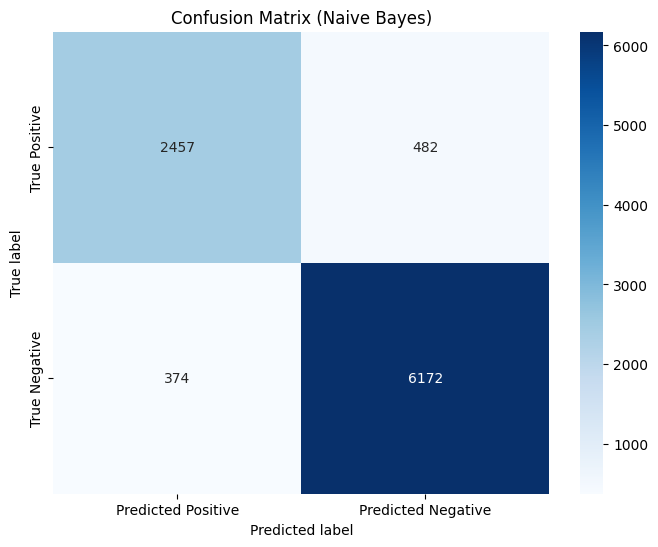

In [39]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Make predictions on the test dataset using the Naive Bayes model
nb_y_pred = nb_model.predict(X_test_tfidf)

# Calculate the confusion matrix for Naive Bayes
nb_cm = confusion_matrix(y_test, nb_y_pred)
print("Confusion Matrix:")
print(nb_cm)
# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(nb_cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['True Positive', 'True Negative'])
plt.title('Confusion Matrix (Naive Bayes)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [40]:
# Naive Bayes
nb_predicted = nb_model.predict(X_test_tfidf)
nb_report = classification_report(y_test, nb_predicted, zero_division=0)

print("Naive Bayes Classification Report:")
print(nb_report)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.84      0.85      2939
    Positive       0.93      0.94      0.94      6546

    accuracy                           0.91      9485
   macro avg       0.90      0.89      0.89      9485
weighted avg       0.91      0.91      0.91      9485



Confusion Matrix:
[[2558  381]
 [ 417 6129]]


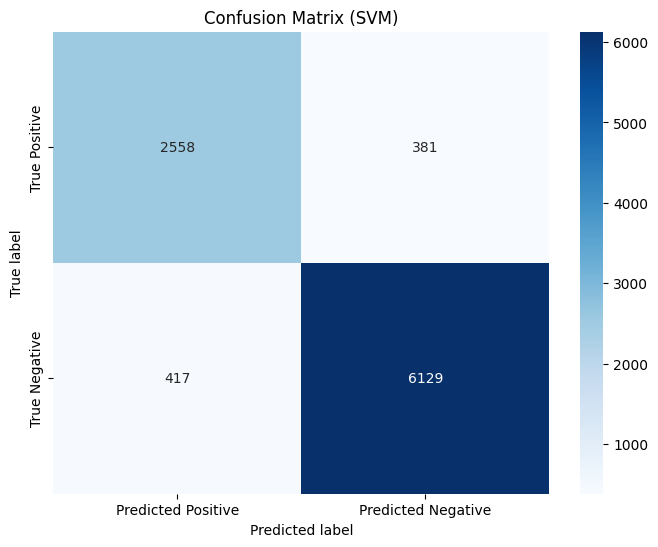

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
svm_predicted = svm_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, svm_predicted)
print("Confusion Matrix:")
print(cm)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['True Positive', 'True Negative'])
plt.title('Confusion Matrix (SVM)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [42]:
# Support Vector Machine (SVM)
svm_predicted = svm_model.predict(X_test_tfidf)
svm_report = classification_report(y_test, svm_predicted, zero_division=0)

print("SVM Classification Report:")
print(svm_report)

SVM Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.87      0.87      2939
    Positive       0.94      0.94      0.94      6546

    accuracy                           0.92      9485
   macro avg       0.90      0.90      0.90      9485
weighted avg       0.92      0.92      0.92      9485



In [43]:
from sklearn.metrics import classification_report

rf_predicted = rf_model.predict(X_test_tfidf)
rf_report = classification_report(y_test, rf_predicted, zero_division=0)

print("Random Forest Classification Report:")
print(rf_report)

Random Forest Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.84      0.85      2939
    Positive       0.93      0.94      0.93      6546

    accuracy                           0.91      9485
   macro avg       0.90      0.89      0.89      9485
weighted avg       0.91      0.91      0.91      9485



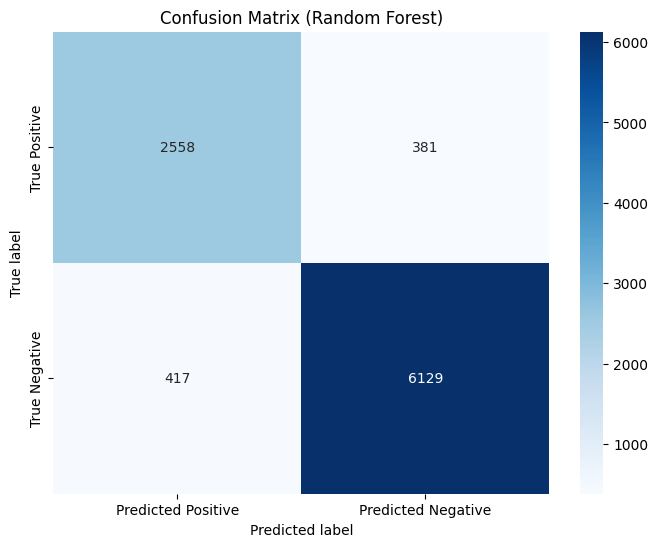

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Positive', 'Predicted Negative'],
            yticklabels=['True Positive', 'True Negative'])
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [45]:
# Calculate the classification report for each model
nb_report = classification_report(y_test, nb_predicted, zero_division=0, output_dict=True)
svm_report = classification_report(y_test, svm_predicted, zero_division=0, output_dict=True)
rf_report = classification_report(y_test, rf_predicted, zero_division=0, output_dict=True)

# Extract the evaluation metrics
nb_precision = nb_report['weighted avg']['precision']
nb_recall = nb_report['weighted avg']['recall']
nb_f1_score = nb_report['weighted avg']['f1-score']
nb_accuracy = nb_report['accuracy']

svm_precision = svm_report['weighted avg']['precision']
svm_recall = svm_report['weighted avg']['recall']
svm_f1_score = svm_report['weighted avg']['f1-score']
svm_accuracy = svm_report['accuracy']

rf_precision = rf_report['weighted avg']['precision']
rf_recall = rf_report['weighted avg']['recall']
rf_f1_score = rf_report['weighted avg']['f1-score']
rf_accuracy = rf_report['accuracy']

# Print the comparison table
print("Comparison of Classification Model's Result")
print("Model\t\tPrecision\tRecall\t\tF-1 Score\tAccuracy")
print("Naive Bayes\t{:.3f}\t\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(nb_precision, nb_recall, nb_f1_score, nb_accuracy))
print("Support Vector Machine\t{:.3f}\t\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(svm_precision, svm_recall, svm_f1_score, svm_accuracy))
print("Random Forest\t{:.3f}\t\t{:.3f}\t\t{:.3f}\t\t{:.3f}".format(rf_precision, rf_recall, rf_f1_score, rf_accuracy))


Comparison of Classification Model's Result
Model		Precision	Recall		F-1 Score	Accuracy
Naive Bayes	0.909		0.910		0.909		0.910
Support Vector Machine	0.916		0.916		0.916		0.916
Random Forest	0.908		0.908		0.908		0.908


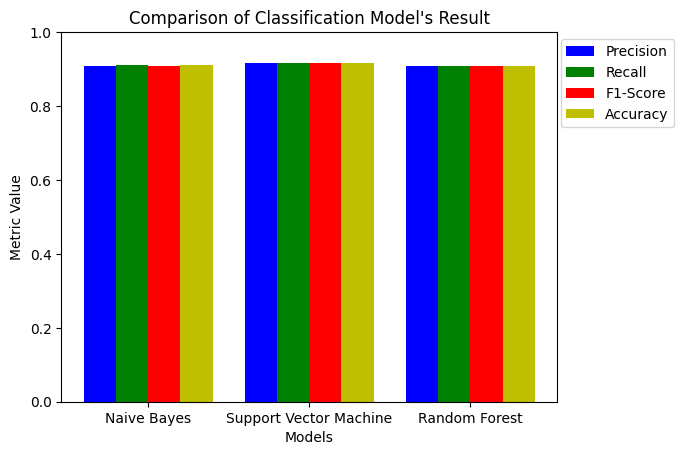

In [46]:
import matplotlib.pyplot as plt

# Define the models and their corresponding metric values
models = ['Naive Bayes', 'Support Vector Machine', 'Random Forest']
precision = [nb_precision, svm_precision, rf_precision]
recall = [nb_recall, svm_recall, rf_recall]
f1_score = [nb_f1_score, svm_f1_score, rf_f1_score]
accuracy = [nb_accuracy, svm_accuracy, rf_accuracy]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bar chart
plt.bar(r1, precision, color='b', width=bar_width, label='Precision')
plt.bar(r2, recall, color='g', width=bar_width, label='Recall')
plt.bar(r3, f1_score, color='r', width=bar_width, label='F1-Score')
plt.bar(r4, accuracy, color='y', width=bar_width, label='Accuracy')

# Add x-axis labels and title
plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.title('Comparison of Classification Model\'s Result')

# Add y-axis range and tick labels
plt.ylim(0, 1)
plt.xticks([r + bar_width * 1.5 for r in range(len(models))], models)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))

# Display the chart
plt.show()


In [47]:
from collections import Counter

# Filter the DataFrame for positive label records
positive_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Positive']

# Concatenate all positive reviews into a single string
positive_reviews = ' '.join(positive_df['stemmed_sentence'])

# Tokenize the string into individual words
positive_tokens = nltk.word_tokenize(positive_reviews)

# Count the frequency of each word
word_freq = Counter(positive_tokens)

# Sort the word frequencies in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Number of top words to retrieve
top_n = 10

# Retrieve the top N words with the highest frequencies
top_words = sorted_word_freq[:top_n]

# Print the top words and their frequencies
for word, freq in top_words:
    print(word, freq)


bagus 11470
dana 4761
bantu 3758
aplikasi 2696
mudah 2232
transaksi 1386
nya 1381
puas 1239
cepat 981
mantap 946


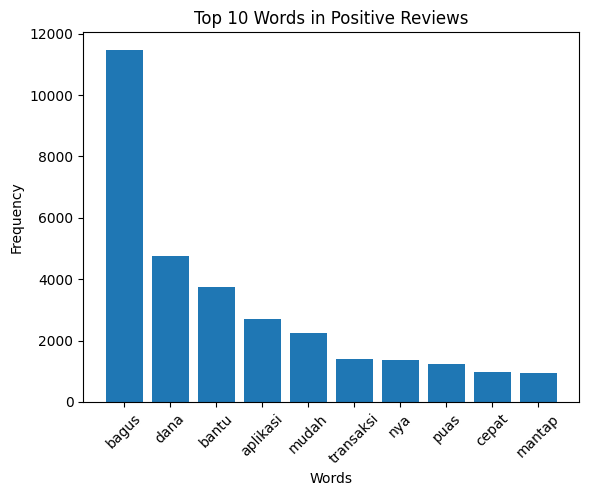

In [48]:
import matplotlib.pyplot as plt

# Retrieve the top N words and their frequencies
top_words = sorted_word_freq[:top_n]

# Extract the words and frequencies into separate lists
words = [word for word, freq in top_words]
frequencies = [freq for word, freq in top_words]

# Create a bar plot
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Words in Positive Reviews'.format(top_n))

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Display the plot
plt.show()


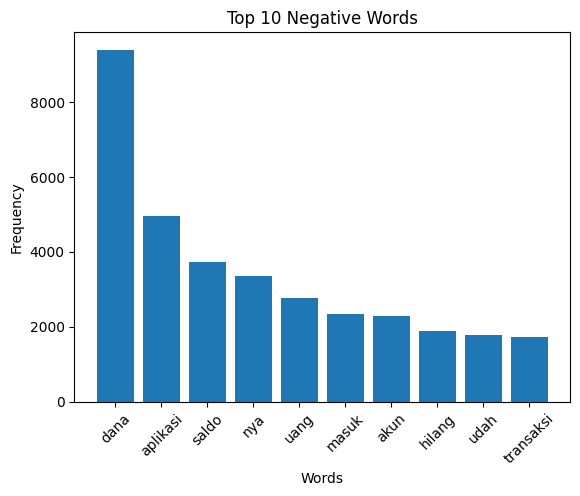

In [49]:
import matplotlib.pyplot as plt
from collections import Counter

# Filter the DataFrame for negative label records
negative_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Negative']

# Concatenate all negative reviews into a single string
negative_reviews = ' '.join(negative_df['stemmed_sentence'])

# Tokenize the string into individual words
negative_tokens = nltk.word_tokenize(negative_reviews)

# Count the frequency of each word
word_freq = Counter(negative_tokens)

# Sort the word frequencies in descending order
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Retrieve the top 10 words with the highest frequencies
top_words = sorted_word_freq[:10]

# Extract the words and frequencies for plotting
words = [word for word, freq in top_words]
frequencies = [freq for word, freq in top_words]

# Create a bar chart
plt.bar(words, frequencies)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Negative Words')
plt.xticks(rotation=45)
plt.show()


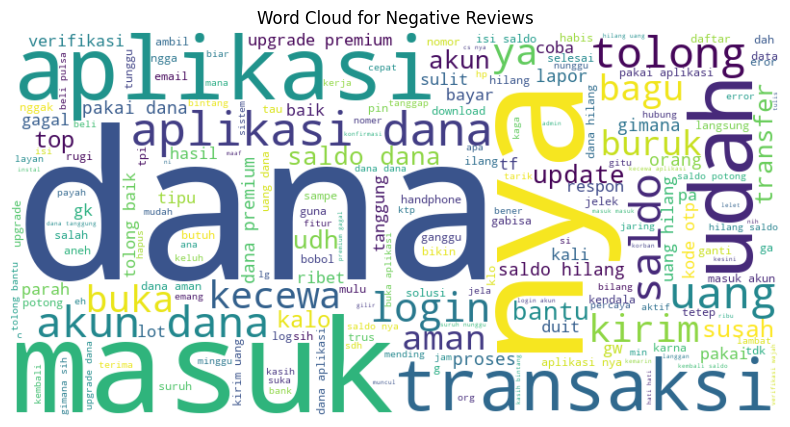

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame for negative label records
negative_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Negative']

# Concatenate all negative reviews into a single string
negative_reviews = ' '.join(negative_df['stemmed_sentence'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


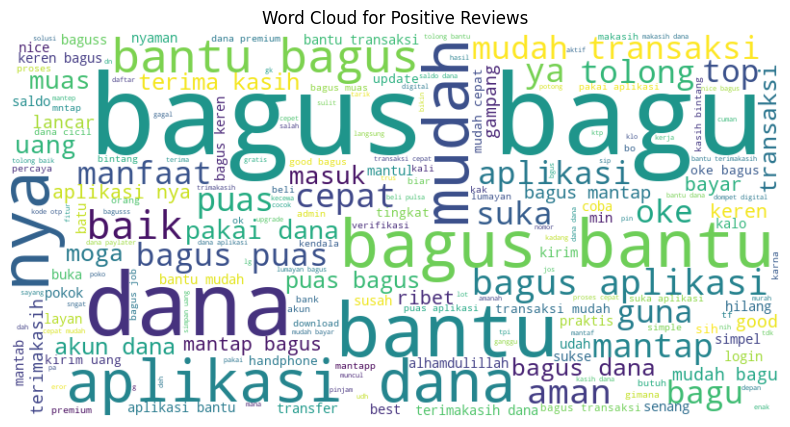

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter the DataFrame for positive label records
positive_df = df_featuresExtraction[df_featuresExtraction['label'] == 'Positive']

# Concatenate all positive reviews into a single string
positive_reviews = ' '.join(positive_df['stemmed_sentence'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()


In [52]:
import joblib

# Assuming your model is named 'svm_model'
joblib.dump(svm_model, 'svm_model.pkl')

# If you also need to save your vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']